# Import Modules

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import json
import glob
import time

# Open Data

In [ ]:
data = {}
for path in glob.glob(r"../../Data/t_taxi/raw_*.csv"):
    data[path.split('\\')[-1].split('.')[0]] = pd.read_csv(path)
data.keys()

In [3]:
with open("../../Data/t_taxi/csv_docs.json", "r") as f:
    docs = json.load(f)

# Select and Adjust Data

In [4]:
h = 30
df = data['raw_dep_h{}'.format(h)]
df['center_crossing'][(df['center_crossing']=='-')|(df['trwy']!='36L')] = np.nan
df['trwy_ext'] = df['trwy'] + ("_" + df['center_crossing']).fillna('')
df.sort_values('t_predict')

X_cols_circ = []
X_cols_num = []
X_cols_cat = []
astype_dict = {}
for col in df.columns:
    if "dtype" == col:
        continue
    if 'circular' in docs[col]['type']:
        X_cols_circ.append(col)
        docs[col]['type'].append("cat") # just to be sure
    if "num" in docs[col]['type']:
        X_cols_num.append(col)
        astype_dict[col] = np.float64
    if "cat" in docs[col]['type']:
        X_cols_cat.append(col)
        astype_dict[col] = "category"
        
X_cols = X_cols_cat + X_cols_num

<ipython-input-4-bf1c06963e14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['center_crossing'][(df['center_crossing']=='-')|(df['trwy']!='36L')] = np.nan


# Model Evaluation Function

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

def model_eval(y, y_pred, name=None, file=None, verbose=True, **kwargs):
    report = {}
    if name:
        report['name'] = name
        if verbose:
            print(name)
    
    report["RMSE"] = mean_squared_error(y, y_pred, squared=False)
    report["MAE"] = mean_absolute_error(y, y_pred)
    report["% <2 min"] = sum(abs(y-y_pred) < 2*60)/len(y)*100
    report["% <5 min"] = sum(abs(y-y_pred) < 5*60)/len(y)*100
    report["% <7 min"] = sum(abs(y-y_pred) < 7*60)/len(y)*100
    report["time"] = str(pd.Timestamp(round(time.time()), unit='s'))
    
    for kwarg in kwargs:
        report[kwarg] = kwargs[kwarg]
    
    if file is not None:
        with open(file, "a") as f:
            f.write(str(report)+"\n")
    if verbose:
        print(report)
    return(report)

# Preprocessor Function

In [6]:
def gen_preprocessor(X_columns):
    ColumnTransformations = []
    num_cols = []
    cat_cols = []
    
    from sklearn.preprocessing import QuantileTransformer
    for col in X_columns:
        if 'circular' in docs[col]['type']:
            ColumnTransformations.append(
            (
                col + '_qcut_' + str(docs[col]['n_bins']),
                QuantileTransformer(n_quantiles=docs[col]['n_bins']),
                [col]
            ))
        if 'num' in docs[col]['type']:
            num_cols.append(col)
        if 'cat' in docs[col]['type']:
            cat_cols.append(col)

    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import Pipeline
    num_trans = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    ColumnTransformations.append(("num_trans", num_trans, num_cols))

    from sklearn.preprocessing import OneHotEncoder
    ColumnTransformations.append(("onehotencode", OneHotEncoder(handle_unknown='ignore'), cat_cols))

    from sklearn.compose import ColumnTransformer
    return ColumnTransformer(ColumnTransformations, remainder='drop', n_jobs=-1)
    

# Calculate cross validated performance for different t_learn

In [7]:
X_cols_sel = ["actype", "depgnr", "n_dep", "dew", "lightning", "rvr5000_2000", "plr1", "plr2", "local_mod", "trwy_ext"]

from sklearn.linear_model import HuberRegressor
regr = HuberRegressor(max_iter=10000)

from sklearn.pipeline import Pipeline

df['t_taxi_end'] = pd.to_datetime(df['t_taxi_end'])
df['mss'] = df['t_taxi_end'].dt.year*12 + df['t_taxi_end'].dt.month
df['mss'] = df['mss'] - min(df['mss'])

results = []

t_learns = [np.Inf, 12, 9, 6, 3, 1]

for t_learn in t_learns:
    print(t_learn)
    for month in range(12,24):
        print(month)
        X_train = df[(df['mss']>= month-t_learn) & (df['mss'] < month)]
        y_train = df[(df['mss']>= month-t_learn) & (df['mss'] < month)]['t_taxi']

        X_test = df[df['mss'] == month]
        y_test = df[df['mss'] == month]["t_taxi"]

        model = Pipeline(steps=[
            ("preprocessor", gen_preprocessor(X_cols_sel)),
            ("regr", regr),  
        ])

        model.fit(X_train, y_train)
        results.append(
            model_eval(
                model.predict(X_test),
                y_test,
                name = "LR_advanced_eval_fixed_m{}".format(month+1),
                n = len(X_test),
                eval_type = 'ADVANCED',
                month=month,
                t_learn = str(t_learn),
                verbose=False
            )
        )

In [8]:
data = pd.DataFrame(results)
data.to_csv("eval_type_results.csv", index=False)

In [2]:
data = pd.read_csv("eval_type_results.csv")

In [5]:
data[data['t_learn']==12].sort_values('% <2 min')

,name,RMSE,MAE,% <2 min,% <5 min,% <7 min,time,n,eval_type,month,t_learn
20,LR_advanced_eval_fixed_m21,196.054510,140.870834,55.047608,89.762848,96.132237,2021-04-20 16:43:16,16909,ADVANCED,20,12.0
16,LR_advanced_eval_fixed_m17,181.933868,132.345897,56.741375,92.003051,96.996010,2021-04-20 16:39:54,17044,ADVANCED,16,12.0
21,LR_advanced_eval_fixed_m22,182.098948,130.444461,58.488220,91.912725,96.829738,2021-04-20 16:44:16,16087,ADVANCED,21,12.0
17,LR_advanced_eval_fixed_m18,182.543160,128.151844,58.932775,92.440492,97.214230,2021-04-20 16:40:46,15292,ADVANCED,17,12.0
15,LR_advanced_eval_fixed_m16,171.873508,124.712942,59.114348,93.328606,97.859997,2021-04-20 16:39:13,15514,ADVANCED,15,12.0
22,LR_advanced_eval_fixed_m23,170.108819,124.051657,59.481223,93.280125,97.940569,2021-04-20 16:45:18,14033,ADVANCED,22,12.0
12,LR_advanced_eval_fixed_m13,186.353321,127.308526,61.035744,92.273210,96.649758,2021-04-20 16:37:04,8477,ADVANCED,12,12.0
14,LR_advanced_eval_fixed_m15,185.744513,126.297950,61.046694,92.522720,96.891257,2021-04-20 16:38:29,15955,ADVANCED,14,12.0
18,LR_advanced_eval_fixed_m19,186.901699,121.566720,62.270842,93.567220,97.391969,2021-04-20 16:41:33,18328,ADVANCED,18,12.0
23,LR_advanced_eval_fixed_m24,161.041041,115.663096,63.427515,94.217058,97.808292,2021-04-20 16:46:17,11361,ADVANCED,23,12.0


# Figure 8: Cross Validation

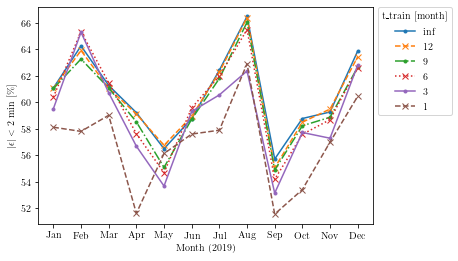

In [26]:
#%matplotlib notebook
import matplotlib.pyplot as plt


markers = ['.', 'x']
linestyles = ['-','--','-.', ':','-','--']

for i, plot in enumerate(data['t_learn'].unique()):
    plt.plot(
        ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
        #data.loc[data['t_learn']==plot, 'month'],
        data.loc[data['t_learn']==plot, '% <2 min'],
        label = str(plot).split(".")[0],
        marker = markers[i%len(markers)],
        linestyle = linestyles[i%len(linestyles)]
    )
    
#plt.xticks(["Jan", "Feb", "Mar", "Apr", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

plt.rc('text', usetex=True)
plt.rc('font', family='Times New Roman')
# plt.rcParams["mathtext.fontset"] = "cm"
plt.ylabel("$|\epsilon| < 2$ min [\%]")
plt.legend(loc='center right', bbox_to_anchor=(1.25,.75), title="t\_train [month]")
plt.xlabel("Month (2019)")


plt.savefig("cross_validated_time_series_split.png", format="png", bbox_inches='tight')
plt.savefig("cross_validated_time_series_split.pdf", format="pdf", bbox_inches='tight')

plt.show()

# Table 8: Cross Validation

In [11]:
rows = []
for row in data['t_learn'].unique():
    row_data = data[data['t_learn']==row]
    rows.append(
        row_data[
            [
                "% <2 min", 
                "RMSE", 
                "MAE", 
                "% <5 min",
                "% <7 min"
            ]
        ].multiply(row_data['n']/sum(row_data['n']), axis=0).sum(axis=0).rename(row)
    )
print(pd.concat(rows, axis=1).T.round(2).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  \% <2 min &    RMSE &     MAE &  \% <5 min &  \% <7 min \\
\midrule
inf  &     60.51 &  176.16 &  124.45 &     92.96 &     97.37 \\
12.0 &     60.38 &  175.98 &  124.49 &     93.01 &     97.38 \\
9.0  &     59.89 &  176.83 &  125.40 &     92.94 &     97.38 \\
6.0  &     59.80 &  177.21 &  125.78 &     92.92 &     97.38 \\
3.0  &     58.84 &  179.22 &  127.76 &     92.65 &     97.33 \\
1.0  &     56.86 &  186.42 &  133.61 &     91.62 &     96.93 \\
\bottomrule
\end{tabular}

